In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.datasets as datasets

# gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
import matplotlib.pyplot as plt
%matplotlib inline

# 防止内核崩溃
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [3]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) # 二维矩阵才能做全连接
        x = self.fc(x)
        return x

In [5]:
def accuracy(y_pred, y_true):
    """
    y_pred (torch.Tensor): 模型的预测输出，形状为 (batch_size, num_classes)。
    y_true (torch.Tensor): 真实标签，形状为 (batch_size)。
    """
    _, pred = torch.max(y_pred, 1)
    correct = (pred == y_true).sum().item()
    return correct / y_true.size(0)

In [6]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
loss_list = []
accuracy_list = []

for epoch in range(epochs):
    running_loss = 0.0
    
    model.train()
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    model.eval()
    with torch.no_grad():
        running_accuracy = 0.0
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / labels.size(0)
            running_accuracy += accuracy
            
    loss_list.append(running_loss / len(train_loader)) # 平均每个batch的loss    
    accuracy_list.append(running_accuracy / len(test_loader)) # 平均每个batch的accuracy
    
    if (epoch+1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {running_accuracy / len(test_loader):.4f}')

Epoch [2/10], Loss: 0.0482, Accuracy: 0.9862
Epoch [4/10], Loss: 0.0276, Accuracy: 0.9902
Epoch [6/10], Loss: 0.0178, Accuracy: 0.9910
Epoch [8/10], Loss: 0.0119, Accuracy: 0.9906
Epoch [10/10], Loss: 0.0090, Accuracy: 0.9900


In [ ]:
# 保存模型
os.makedirs('models', exist_ok=True)
torch.save(model, 'models/CNN_Mnist.pth')

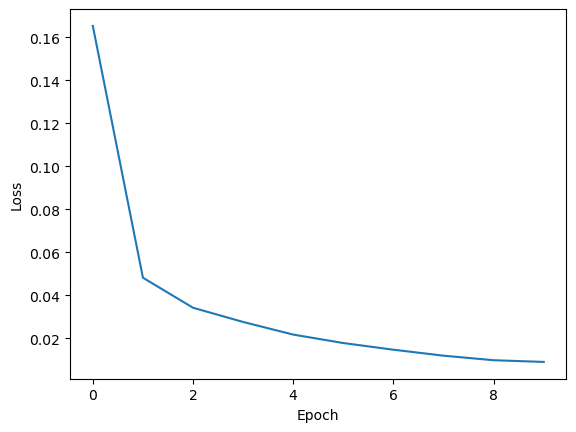

In [ ]:
# 可视化loss
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.close()

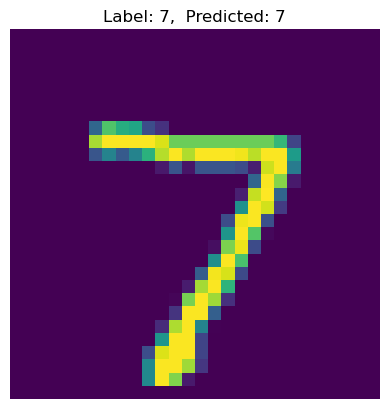

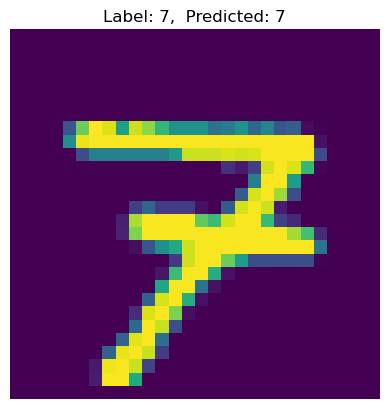

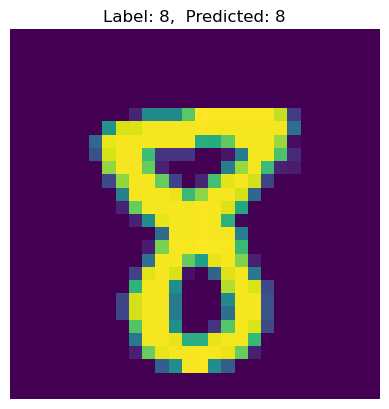

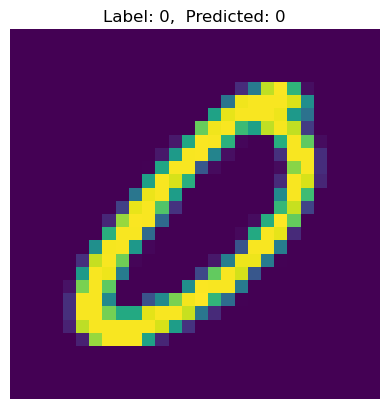

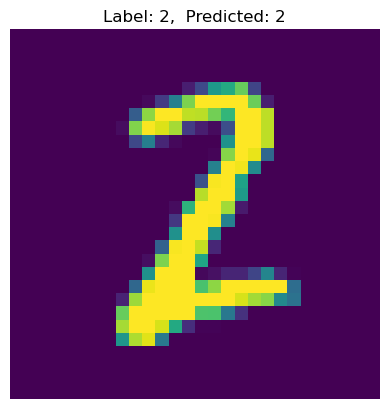

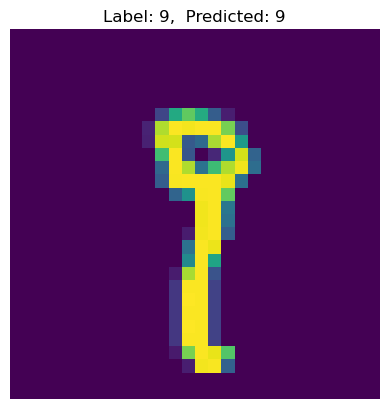

In [ ]:
# 预测演示
with torch.no_grad():
        running_accuracy = 0.0
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            img = inputs[0].cpu().numpy().squeeze()  # 将图片从 GPU 移动到 CPU，并转换为 numpy 数组

            plt.imshow(img)
            plt.title(f'Label: {labels[0]},  Predicted: {predicted[0]}')
            plt.axis('off')
            plt.show()
            plt.close()
            
            if i == 5:  # 只显示前10张图片
                break